In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def fit(x, a, b, sigma, c):
    return (1 / (a + b * np.exp(-sigma * x))) + c

def m_stretched(phi, C, A, phi0, beta):
    return C + A * np.exp(- (phi/phi0)**beta)

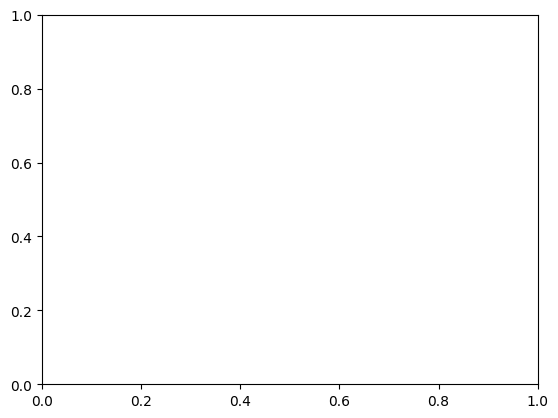

In [35]:
foldername = './Series/series_388.3nm_fluence.csv'
df = pd.read_csv(foldername)
#print(df)

fig, ax = plt.subplots()
fluence = df['Fluence_(ions_cm^-2)'][1:]
counts = df['Counts'][1:]
#ax.semilogy(fluence, counts, marker='o', linestyle='None')
#ax.scatter(df['Fluence_(ions_cm^-2)'][1:], df['Counts'][1:], marker='o')

Fitted parameters: a=-2942985326.3639545, b=-14644483.134341082, sigma=1e-16, c=244.4289402260047


C:\Users\steve\AppData\Local\Temp\ipykernel_15456\910311978.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(fit, fluence, counts, p0=(1e4, 1, 1e-16, 1))


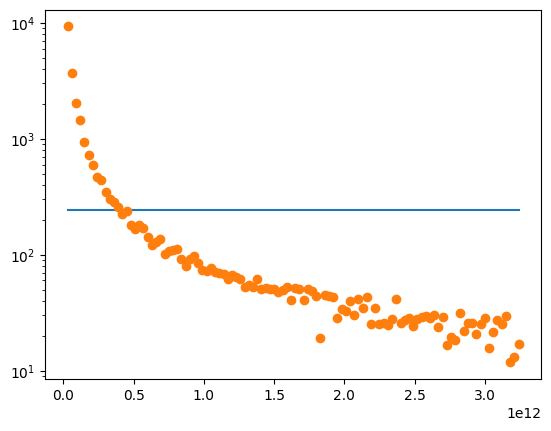

In [32]:
popt, pcov = curve_fit(fit, fluence, counts, p0=(1e4, 1, 1e-16, 1))
afit, bfit, sigmafit, cfit = popt
print(f"Fitted parameters: a={afit}, b={bfit}, sigma={sigmafit}, c={cfit}")

fig2, ax2 = plt.subplots()

yfit = fit(fluence, *popt)
ax2.semilogy(fluence, yfit, label='Fitted curve')
ax2.semilogy(fluence, counts, marker='o', linestyle='None', label='Data')
plt.show()

exp         AIC=     1056.64  params=[8.65473707e+01 1.91477124e+04 2.50936077e-11]
stretched   AIC=      591.23  params=[2.36485608e+01 2.69871487e+11 2.20590143e-06 7.65538603e-02]
power       AIC=      570.99  params=[1.87975431e+01 1.30527305e+05 6.73306629e+09 1.55629941e+00]
bi-exp      AIC=      754.86  params=[4.54330363e+01 2.49043509e+04 4.02410742e-11 2.18882697e+03
 6.11637857e-12]

Best model: power  AIC=570.99


C:\Users\steve\AppData\Local\Temp\ipykernel_15456\2345239006.py:14: RuntimeWarning: invalid value encountered in power
  return C + A * np.exp(- (phi/phi0)**beta)
C:\Users\steve\AppData\Local\Temp\ipykernel_15456\2345239006.py:17: RuntimeWarning: invalid value encountered in power
  return C + A * (1.0 + phi/phi0)**(-n)


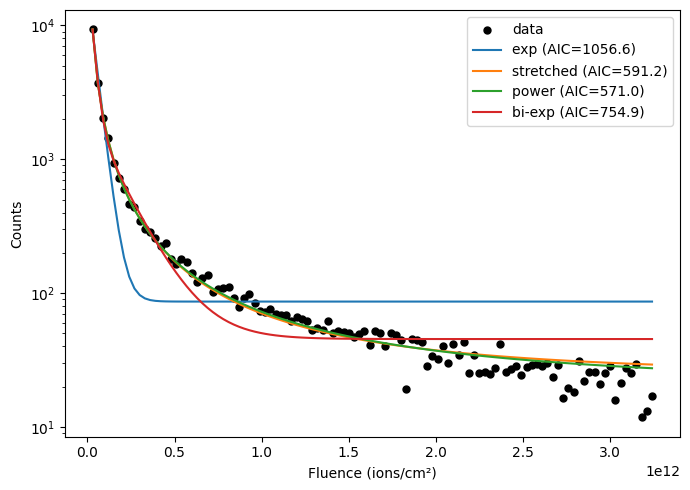

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

phi = df["Fluence_(ions_cm^-2)"].to_numpy(float)[1:]
y = df["Counts"].to_numpy(float)[1:]

# --- Define candidate models
def m_exp(phi, C, A, k):
    return C + A * np.exp(-k*phi)

def m_stretched(phi, C, A, phi0, beta):
    return C + A * np.exp(- (phi/phi0)**beta)

def m_power(phi, C, A, phi0, n):
    return C + A * (1.0 + phi/phi0)**(-n)

def m_biexp(phi, C, A1, k1, A2, k2):
    return C + A1*np.exp(-k1*phi) + A2*np.exp(-k2*phi)

models = {
    "exp": (m_exp,   [np.min(y), np.max(y)-np.min(y), 1e-12]),
    "stretched": (m_stretched, [np.min(y), np.max(y)-np.min(y), 5e11, 0.6]),
    "power": (m_power, [np.min(y), np.max(y)-np.min(y), 5e11, 1.0]),
    "bi-exp": (m_biexp, [np.min(y), (np.max(y)-np.min(y))/2, 1e-12,
                          (np.max(y)-np.min(y))/2, 1e-13])
}

def fit_and_aic(model, x, y, p0):
    popt, _ = curve_fit(model, x, y, p0=p0, maxfev=20000)
    yhat = model(x, *popt)
    resid = y - yhat
    n, k = len(y), len(popt)
    rss = np.sum(resid**2)
    aic = n*np.log(rss/n + 1e-300) + 2*k
    return popt, yhat, aic

# --- Fit all models
results = {}
for name, (func, p0) in models.items():
    try:
        popt, yhat, aic = fit_and_aic(func, phi, y, p0)
        results[name] = (popt, yhat, aic)
        print(f"{name:10s}  AIC={aic:12.2f}  params={popt}")
    except Exception as e:
        print(f"{name:10s}  failed: {e}")

# --- Determine best fit
best = min(results.items(), key=lambda kv: kv[1][2])
best_name, (best_popt, best_yhat, best_aic) = best
print(f"\nBest model: {best_name}  AIC={best_aic:.2f}")

# --- Plot
plt.figure(figsize=(7,5))
plt.scatter(phi, y, s=25, color='k', label='data')
for name, (popt, yhat, aic) in results.items():
    plt.plot(phi, yhat, label=f"{name} (AIC={aic:.1f})")
plt.xscale('linear')
plt.yscale('log')
plt.xlabel("Fluence (ions/cm²)")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()
plt.show()
